In [38]:
#Library to read audio file
import librosa
import librosa.display

#base
import numpy as np
import pandas as pd

#plot
import matplotlib.pylab as plt
import seaborn as sns

#save
import skimage.io

from pprint import pprint

In [45]:
with np.printoptions(precision=10, suppress=True):

  params = np.linspace(0.01, 0.75, 99)

  pprint(list(zip(range(0, 99), list(params))))

[(0, 0.01),
 (1, 0.017551020408163268),
 (2, 0.025102040816326533),
 (3, 0.0326530612244898),
 (4, 0.040204081632653065),
 (5, 0.04775510204081633),
 (6, 0.055306122448979596),
 (7, 0.06285714285714286),
 (8, 0.07040816326530612),
 (9, 0.07795918367346939),
 (10, 0.08551020408163265),
 (11, 0.09306122448979591),
 (12, 0.10061224489795918),
 (13, 0.10816326530612246),
 (14, 0.11571428571428571),
 (15, 0.12326530612244897),
 (16, 0.13081632653061226),
 (17, 0.13836734693877553),
 (18, 0.1459183673469388),
 (19, 0.15346938775510205),
 (20, 0.16102040816326532),
 (21, 0.1685714285714286),
 (22, 0.17612244897959184),
 (23, 0.1836734693877551),
 (24, 0.19122448979591838),
 (25, 0.19877551020408166),
 (26, 0.20632653061224493),
 (27, 0.21387755102040817),
 (28, 0.22142857142857145),
 (29, 0.22897959183673472),
 (30, 0.23653061224489796),
 (31, 0.24408163265306124),
 (32, 0.2516326530612245),
 (33, 0.25918367346938775),
 (34, 0.26673469387755105),
 (35, 0.2742857142857143),
 (36, 0.28183673469

# Plot the Mel Spectrogram

In [6]:
#y  = raw data of the audio file
#sr = sample rate - integer value of the sample rate 
y, sr = librosa.load("000000.mp3")


In [7]:
D = librosa.stft(y)

In [8]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

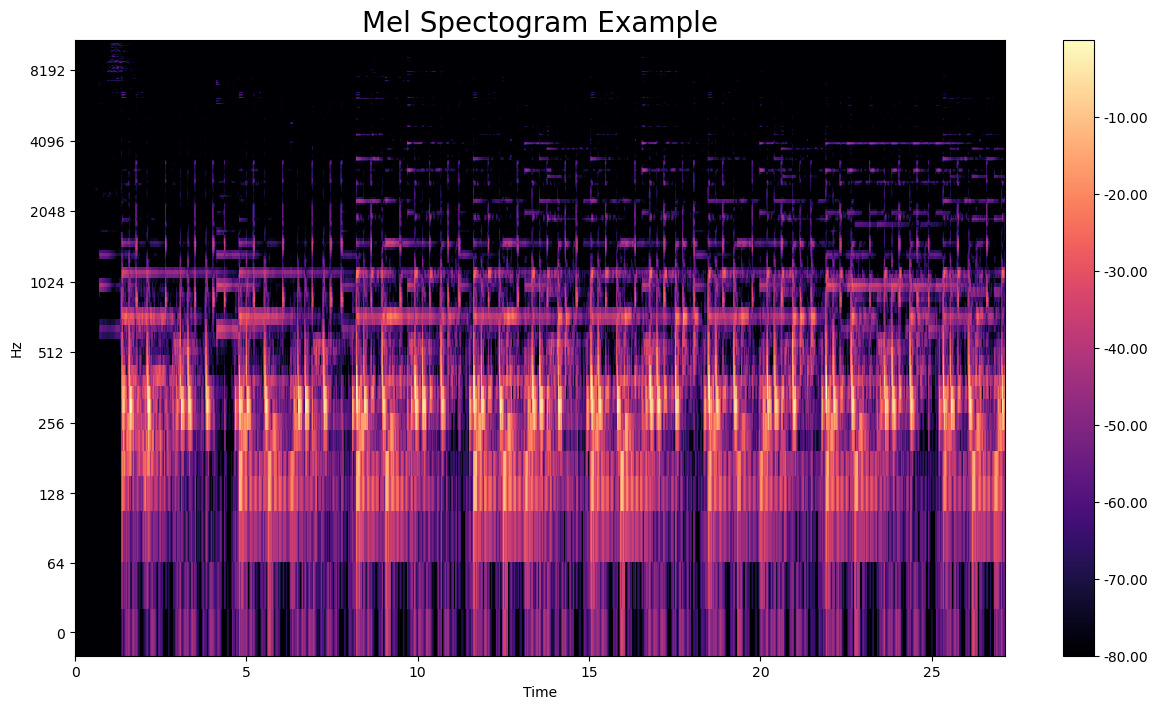

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# Save the MelSPectogram as .png

In [10]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [11]:
def spectrogram_image(y, sr, out, hop_length, n_mels):
    
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y,
                                        sr=sr,
                                        n_mels=n_mels,)
    S_db_mel = librosa.amplitude_to_db(mels, ref=np.max)


    #Why
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # # min-max scale to fit inside 8-bit range
    # img = scale_minmax(mels, 0, 255).astype(np.uint8)
    # img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    # img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, mels)

In [12]:
def saveMelSpectogram(width: int, height: int, fileName: str):
    # settings
    hop_length = 512 # number of samples per time-step in spectrogram
    n_mels = height # number of bins in spectrogram. Height of image
    time_steps = width # number of time-steps. Width of image

    # load audio. Using example from librosa
    y, sr = librosa.load(fileName, offset=1.0, duration=10.0, sr=22050)
    out = f'MS_{fileName}out.png'
    
    # convert to PNG
    spectrogram_image(y, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)
    print('wrote file', out)

In [19]:
saveMelSpectogram(1024, 512, "file_example_MP3_1MG.mp3")

Lossy conversion from float32 to uint8. Range [-20.723237991333008, 8.16768741607666]. Convert image to uint8 prior to saving to suppress this warning.


wrote file MS_file_example_MP3_1MG.mp3out.png


# PyTorch and torchaudio

In [14]:
import torchaudio
import torchaudio.transforms
import torch

In [15]:
waveform, sample_rate = torchaudio.load("file_example_MP3_1MG.mp3", normalize=True)

In [16]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

c:\Users\matteo\anaconda3\lib\site-packages\torchaudio\functional\functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


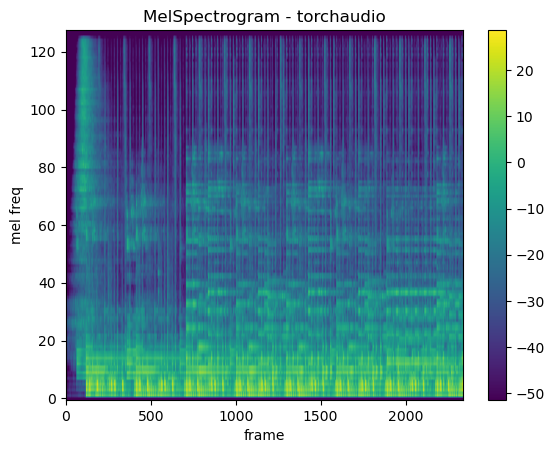

In [17]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')